# Social Network Analysis - Exercise Sheet 3


## Exercise 3a) Distances in Directed Graphs.

In this exercise, we will work with directed graphs. In particular, we look at measures of *distance* between nodes in a graph. In the tasks below, you will think about the properties of measures depending on properties of the graph. You will then define and implement some distance measures on your own and use these to generate graphs based on distance thresholds. Your implementations will be applied to some real world data set.

### Guidelines
* Submit your code zipped via [moodle](https://moodle.uni-kassel.de/course/view.php?id=18460) until 29.06.2025 23:55 MEZ
* Use the [NetworkX](https://networkx.github.io/documentation/stable/) library for your graphs.

### Exercise 3a.1
A metric $d$ on a set $X$ is a function $d: X \times X \mapsto \mathbb{R}$ such that for some arbitrary $x,y,z \in X$ the following properties hold:
1. $d(x,y) \geq 0$ and $d(x,y) = 0 \iff x = y$
2. $d(x,y) = d(y,x)$ (Symmetry)
3. $d(x,y) \leq d(x,z) + d(z,y)$ (Triangle Inequality)

Based on the definition above, solve the following tasks (text only):
1. Recall the directed graph distance function from the lecture. In this exercise, we will call this the *geodesic distance*. Is the directed graph distance function described in the lecture a metric? Discuss the three properties above.
* Under which circumstances does the geodesic distance become a metric on the vertices of a DiGraph?
* What can geodesic distances tell us about a graph?
* How is the geodesic distance related to Point Bases?
* Find and describe at least two real-world examples where geodesics are useful.

### **Exercise 3a.1**

1. **Is the directed graph distance a metric?**  
   - **No**, because it **violates symmetry** (by 6.22).  
   - Satisfies non-negativity (by 6.21) and triangle inequality(by 6.23).

2. **When is geodesic distance a metric in a DiGraph?**  
   - between all nodes must exist a **symmetric path**

3. **What can geodesic distances tell us?**  
   - Node **centrality** and **reachability**.  
   - Graph **structure**, **efficiency**, and **clustering**.  
   - Helps identify **bottlenecks** or **key nodes**.

4. **Relation to Point Bases:** 
   - Measures how **effectively** a point basis **covers** the graph.  
   - Affects **reachability** and **optimal selection** of base nodes.

5. **Real-world examples:**  
   - **GPS Navigation**: Shortest driving paths.  
   - **Social Networks**: Degrees of connection between users.

### Exercise 3a.2:
* Implement an algorithm to compute geodesic distances in a directed graph. You must implement this algorithm on your own, i.e., you are not allowed to use the *networkx* method which computes this. However, you can use other methods from *networkx*.
* Think of how, based on geodesic distances, **symmetric** distances can be defined that tell us something about a directed graph.
    * Define, explain and implement three examples for such distances.
    * Give at least one example that also fullfills the triangle inequality.
    * If neccesary, you can define conditions on the graph under which distances can be computed. In this case, your implementation should test for the conditions and handle them accordingly.
* Implement a method which takes as its parameters a directed graph, a distance function $d$ and a lower and an upper treshold. Based on this, the method returns an undirected, edge-weighted graph with the weights $w(u,v) = d(u,v)$.
    * In the resulting graph, an edge $\{u,v\}$ should exist if and only if the distance $d(u,v)$ is greater than or equal to the lower treshold value and lower than the upper treshold.
* Apply your implementation to a real world data set. Visualize and interpret the results. If one of your distance measures only works with certain kinds of graphs, try to find a way to solve this.

In [1]:
import networkx as nx
from collections import deque


def geodesic_distances(G):
    
    d = {}
    
    for source in G.nodes:
        
        d[source] = {node: float('inf') for node in G.nodes}
        d[source][source] = 0
        queue = deque([source])
        
        while queue:
            u = queue.popleft()
            
            for v in G.successors(u):
                
                if d[source][v] == float('inf'):
                    d[source][v] = d[source][u] + 1
                    queue.append(v)
    return d


symmetric_metrics = {

    # Max Distance
    'max': lambda d, u, v: max(d[u][v], d[v][u]),  # fullfils Triangle Inequality
    
    # Average Distance
    'avg': lambda d, u, v: (d[u][v] + d[v][u]) / 2 if d[u][v] != float('inf') and d[v][u] != float('inf') else float('inf'),

    # Min Distance
    'min': lambda d, u, v: min(d[u][v], d[v][u]) if d[u][v] != float('inf') and d[v][u] != float('inf') else float('inf')
}


def threshold_graph(G, d, sym_func, lower, upper):
    
    H = nx.Graph()
    H.add_nodes_from(G.nodes)
    
    for u in G.nodes:
        for v in G.nodes:
            
            if u != v:
                d_sym = sym_func(d, u, v)
                
                if lower <= d_sym <= upper:
                    H.add_edge(u, v, weight=d_sym)
    return H

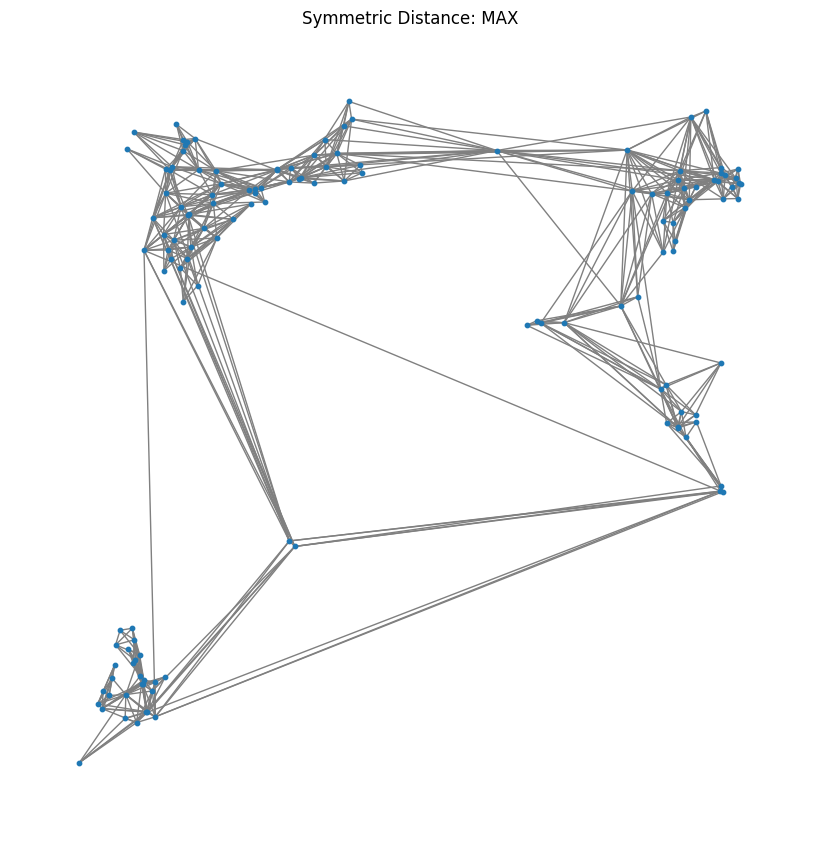

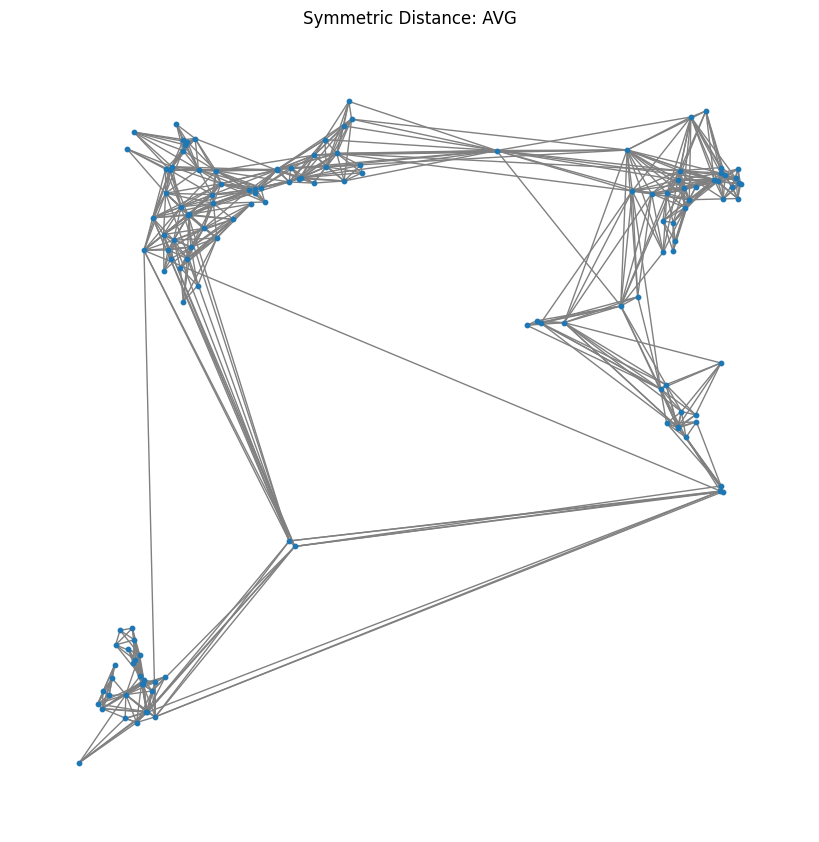

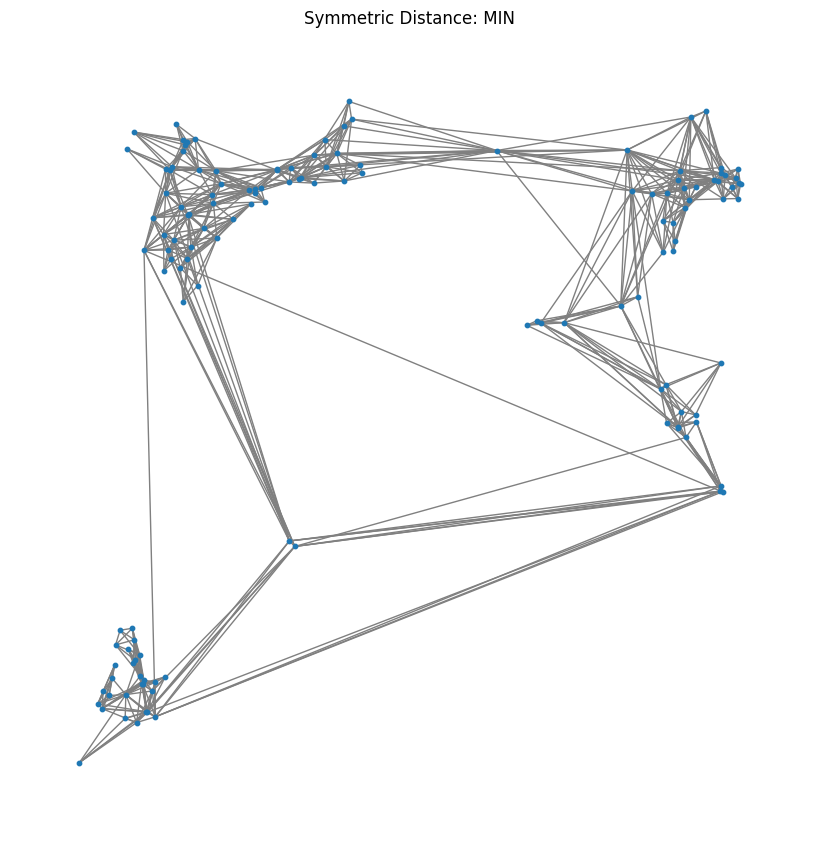

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

ox.settings.use_cache = True
ox.settings.log_console = False
G = ox.graph_from_point((50.8, 8.7), dist=2000, network_type="drive")

# Convert from MultiDiGraph to DiGraph
G_simple = nx.DiGraph()
for u, v, data in G.edges(data=True):
    if not G_simple.has_edge(u, v):
        G_simple.add_edge(u, v, **data)

d = geodesic_distances(G_simple)


for name, sym_func in symmetric_metrics.items():
    H = threshold_graph(G_simple, d, sym_func, lower=0, upper=3)

    
    largest_cc = max(nx.connected_components(H), key=len)
    pos = {n: (data['x'], data['y']) for n, data in G.nodes(data=True)}

    plt.figure(figsize=(8, 8))
    nx.draw(H.subgraph(largest_cc), pos=pos, node_size=10, edge_color='gray')
    plt.axis('off')
    plt.title(f"Symmetric Distance: {name.upper()}")
    plt.show()

## Exercise 3b) Small World Networks

Small-world networks were introduced by Duncan Watts and Steven Strogatz in a paper in *Nature* in 1998. 
They are linked to the small world phenomenon, that describes the property of social networks to have small average path lengths. Additionally Watts and Strogatz observed that there are networks where the neighborhood of every node is densly connected, a property that random networks usually do not exhibit.
In their paper they investigated this phenomenon and coined the term small-world networks.
The paper is supplied together with the jupyter notebook.

---

Given a Graph $(V,E)$ the **average shortest path** ($ASP$) in a Graph is defined by $ASP := \sum_{u,v\in V}\frac{d(u,v)}{|V|(|V|-1)}$ where $d(u,v)$ is the shortest path from $u$ to $v$.

The **local clustering coefficient** of a node in an undirected graph $C_i$ for $i\in V$ is defined by the ratio of edges in the neighborhood of $i$ compared to the number of possible edges, i.e., $C_i := \frac{2|\{e_{jk}: v_j,v_k \in N_i, e_{jk} \in E\}|}{|N_i|(|N_i|-1)}$ where $N_i$ is the neighborhood of the node $i$. 

Remark: $|N_i|(|N_i|-1)/2$ is the number of edges in a fully connected neighborhood, i.e., if the neighborhood would form a complete subgraph.

The **average local clustering coefficient** ($ALCC$) is defined as the average over all local clustering coefficients, i.e., $ ALCC := \frac{1}{|V|}\sum_{i=1}^{|V|} C_i$.

The definition of a small world network is as follows:

A network is called a **small-world network** if its average shortest path ($ASP$) is small and after the networks edges have pairwise been randomized (typically around $100\cdot |E|$ times) the $ASP$ remains nearly unchanged but the average local clustering coefficient ($ALCC$) breakes down, i.e., $$ASP_{actual} \approx APS_{randomized}$$ and $$ALCC_{actual} \gg ALCC_{randomized}.$$

Remark: For small-world social networks an $ASP\leq 4$ and an $ALCC\geq 70\%$ are common, for other networks, e.g., the ones mentioned in the paper, smaller $ALCC$ values and larger $ASP$ values are also normal. The important part is the breaking down of the $ALCC$ when comparing to a randomized network.


#### Edge Randomization

The **edge randomization** should choose two edges uniformly at random from the edge set and swap nodes, e.g., edges $(a,b)$ and $(c,d)$ swap nodes and become $(a,d)$ and $(c,b)$. The method should keep the node degrees intact.
To achive this it must be checked whether the edges have common nodes and whether the edges that would be generated through swapping already exist.

For solving this exercise, use "Watts_Strogatz_small-world-networks.pdf" and "Floyd_Warshall_undirected.pdf".

## Exercise
1. Implement an algorithm to compute the ASP. As an intermediate step implement the Floyd-Warshall algorithm for undirected graphs (see above) to compute all shortest paths.
2. Implement an algorithm to compute the ALCC.
3. Implement the edge randomization as presented above.
4. Analyze the given Networks with regard to the small world property and write a short report containing the computations and the conclusions you draw. Since this is a Jupyter Notebook, simply use different Cells for the Text and Code parts in the Report section below.


## Hints
* You can use the [NetworkX](https://networkx.github.io/documentation/stable/) library.
* Below the Implementation section is a Test section that can be used to check your code.

## Implementation
Implement your solution in this section.
Use the predefined methods.
You can add more methods if you want.

In [3]:
import random as rd
import networkx as nx
import matplotlib.pyplot as plt
import collections
import numpy as np

def floyd_warshall(G):
    
    nodes = list(G.nodes())
    n = len(nodes)
    dist = {u: {v: float('inf') for v in nodes} for u in nodes}
    
    for u in nodes:
        dist[u][u] = 0
    
    for u, v in G.edges():
        dist[u][v] = 1
        dist[v][u] = 1
    
    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][j] > dist[i][k] + dist[k][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
    
    return dist

def average_shortest_path(G):
    
    dist = floyd_warshall(G)
    total = 0
    count = 0
    
    for u in G.nodes():
        for v in G.nodes():
            
            if u != v and dist[u][v] != float('inf'):
                total += dist[u][v]
                count += 1
    
    ASP = total / count if count > 0 else 0
    return ASP

def average_local_clustering_coefficient(G):
    return nx.average_clustering(G)

def randomize_edges(G, n=100):
    
    p = 0.1
    nodes = list(G.nodes())
    new_G = nx.Graph()
    new_G.add_nodes_from(nodes)
    k = len(list(G.neighbors(nodes[0])))  # Assuming regular ring lattice
    
    for node in nodes:
        neighbors = sorted(G.neighbors(node))
        
        for neighbor in neighbors:
            
            if node < neighbor:  # Avoid duplicates
                if rd.random() < p:
                    
                    new_target = rd.choice(nodes)
                    
                    while new_target == node or new_G.has_edge(node, new_target):
                        new_target = rd.choice(nodes)
                        
                    new_G.add_edge(node, new_target)
                    
                else:
                    new_G.add_edge(node, neighbor)
    
    return new_G

## Tests 
This section contains testcases that can be used to test if the implemented methods work correctly.
Further it contains code to draw the graphs and inspect them visually given the NetworkX library was used.

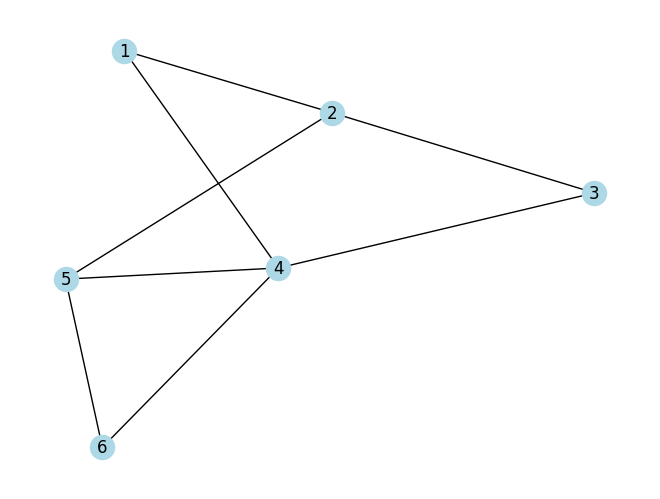

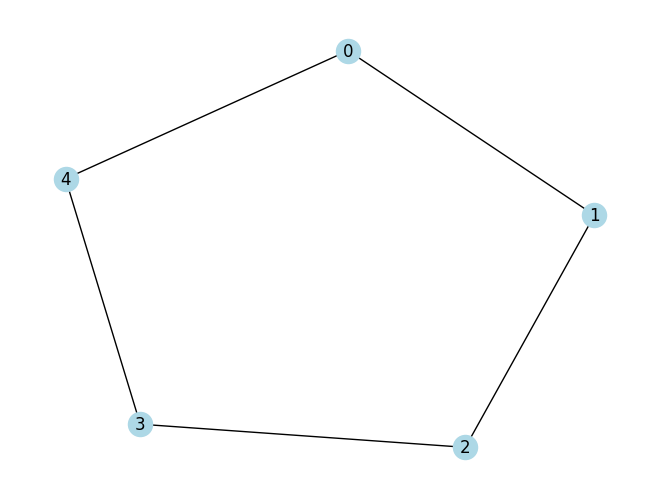

Todo está bien 😃


In [4]:
# Testcase 1
G = nx.Graph([[1, 2], [2, 3], [2, 3], [2, 5], [3, 4], [1, 4], [4, 5], [4, 6], [5, 6]])
assert abs(1.46666666 - average_shortest_path(G)) < 0.001
assert abs(0.25 - average_local_clustering_coefficient(G)) < 0.001
degree_sequence = sorted([v for n, v in nx.degree(G)], reverse=True)
randomize_edges(G, 100 * len(G.edges()))
degree_sequence_after_random = sorted([v for n, v in nx.degree(G)], reverse=True)
assert degree_sequence == degree_sequence_after_random
nx.draw(G, with_labels=True, node_color="lightblue")
plt.show()

# Testcase 2
G = nx.read_adjlist("./graphs/five_circle_testgraph.adjlist")
assert abs(1.5 - average_shortest_path(G)) < 0.001
assert abs(0 - average_local_clustering_coefficient(G)) < 0.001
degree_sequence = sorted([v for n, v in nx.degree(G)], reverse=True)
randomize_edges(G, 100 * len(G.edges()))
degree_sequence_after_random = sorted([v for n, v in nx.degree(G)], reverse=True)
assert degree_sequence == degree_sequence_after_random
nx.draw(G, with_labels=True, node_color="lightblue")
plt.show()

# Testcase 3
G = nx.read_adjlist("./graphs/testgraph.adjlist")
assert abs(2.8783 - average_shortest_path(G)) < 0.001
assert abs(0.45019 - average_local_clustering_coefficient(G)) < 0.001
degree_sequence = sorted([v for n, v in nx.degree(G)], reverse=True)
randomize_edges(G, 100 * len(G.edges()))
degree_sequence_after_random = sorted([v for n, v in nx.degree(G)], reverse=True)
assert degree_sequence == degree_sequence_after_random

print("Todo está bien \U0001f603")

## Report

Analyze the given Networks with regard to the the small world property and write a short report containing the computations and the conclusions you draw. Since this is a Jupyter Notebook, simply use different Cells for the Text and Code parts.

The Report should contain basic information about the networks, e.g., number of nodes, and answer the question whether or not the network fits the definition of small world networks.


The networks are:


* **David Copperfield**
    * This is the undirected network of common noun and adjective adjacencies for the novel "David Copperfield" by English 19th century writer Charles Dickens. A node represents either a noun or an adjective. An edge connects two words that occur in adjacent positions. The network is not bipartite, i.e., there are edges connecting adjectives with adjectives, nouns with nouns and adjectives with nouns.

* **Jazz musicians**
    * This is the collaboration network between Jazz musicians. Each node is a Jazz musician and an edge denotes that two musicians have played together in a band. The data was collected in 2003.
    
* **Zachary karate club**
    * This is the well-known and much-used Zachary karate club network. The data was collected from the members of a university karate club by Wayne Zachary in 1977. Each node represents a member of the club, and each edge represents a tie between two members of the club. The network is undirected. An often discussed problem using this dataset is to find the two groups of people into which the karate club split after an argument between two teachers.    

#### David Copperfield

In [5]:
G = nx.read_gml("./graphs/adjnoun.gml")
print(average_local_clustering_coefficient(G))
print(average_shortest_path(G))
G = randomize_edges(G)
print(average_local_clustering_coefficient(G))
print(average_shortest_path(G))

# No small world, because ALCC doesn't decreases strongly

0.17284007981036792
2.5355534105534105
0.1760076034337197
2.506113256113256


#### Jazz musicians

In [6]:
G = nx.read_edgelist("./graphs/out.arenas-jazz", comments='%', delimiter='\t', nodetype=int)
print(average_local_clustering_coefficient(G))
print(average_shortest_path(G))
G = randomize_edges(G)
print(average_local_clustering_coefficient(G))
print(average_shortest_path(G))

# Small world, because ASP small, ALCC over 0.1 and ASP stays consistent and ALCC decreases strongly

0.6174507021536301
2.2350407629595446
0.4868062807961595
2.049052108152906


#### Zachary karate club

In [7]:
G = nx.read_edgelist("./graphs/out.ucidata-zachary", comments='%', delimiter=' ', nodetype=int)
print(average_local_clustering_coefficient(G))
print(average_shortest_path(G))
G = randomize_edges(G)
print(average_local_clustering_coefficient(G))
print(average_shortest_path(G))

# Small world, because ASP small, ALCC over 0.1 and ASP stays consistent and ALCC decreases strongly

0.5706384782076823
2.408199643493761
0.5696895424836601
2.445632798573975


## Exercise 3c) Bipartite Graph Generators

The random generation of graphs is important for the task of network analysis.
There is a multitude of random generators for graphs available, the most prominent being the Erdős–Rényi model.
In the field of social network analysis the Watts and Strogatz model (small-worlds) and the Barabási–Albert model (scale-free networks with preferential attachment) also became prominent generation models to more adequately generate networks mimicking at least some aspects of empirically observed networks.

However, none of these models can be used as is to generate bipartite graphs and bipartite graphs were analyzed by projecting them to both partitions and analyzing the projected graphs using standard graph measures. 
This way of analyzing bipartite networks drew criticism for not resulting in 

Therefore, it was nessessary to come up with more appropriate generation models for this important class of networks.

For solving this exercise, use "Bipartite_graphs_as_models_of_complex_networks.pdf".

### Preferential Attachment

Preferential attachment means that the more connected a node is, the more likely it is to receive new links. Nodes with higher degree have stronger ability to grab links added to the network.

Formally:
The probability that a new node is connected to the node $i$ is $$p_i = \frac{k_i}{\sum_j k_j}$$
where $k_i$ is the degree of node $i$ and the sum is made over all pre-existing nodes $j$.


*Hints:*
* Only look at bottom nodes not yet connected to the new top node.
* You can use *stats.rv_discrete* to create the probability distribution for the new edge.

## Exercise
1. **Implementation of the generator:** Implement the algorithm to generate bipartite random graphs described in section 4.2. "Growing bipartite model with preferential attachment" in the paper "Bipartite graphs as models of complex networks" (2006).
The generator should accept discrete scipy [Distributions](https://docs.scipy.org/doc/scipy/reference/stats.html) as input distributions for the degree distributions. Bipartite graphs shohuld be represented in networkx by [coloring](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.bipartite.html), i.e., using an attribute `bipartite` to distinguish the nodes where `bipartite=0` identifies top nodes and `bipartite=1` identifies bottom nodes.
2. **Implementation of projection and analysis:** Implement a function to project bipartite graphs onto the top and bottom sets using the networkx functionality. Implement functions Connected, ASP, ALCC, Density and ADeg. You can either use your own implementation or networkx functionality. *Hint: When using networkx most of the functions become one-liners.* 
3. **Evaluation of generated and projected bipartite graphs:** Generate three networks for the given parameters (parameters can be found in the corresponding section) analyze them with respect to connectedness, average shortest path, average local clustering coefficient, density and average degree. Project each network onto both partitions and analyze the projected network with respect to the same properties. 

##### Hints
* You can use the [NetworkX](https://networkx.github.io/documentation/stable/) library. 
* Watch out which networkx version you are working with `print(nx.__version__)` and use only the documentation corresonding to that version!
* Below the Implementation section is a Test section that can be used to check your code.

### Implementation
Implement your solution in this section.
Use the predefined methods.
You can add more methods if you want.

In [8]:
import scipy.stats as stats
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import random as rd


def bipartite_graph_generator(top_distribution=stats.binom(10, 0.25), number_of_top_nodes=25, overlap_ratio=0.5):
    assert(overlap_ratio <=1)
    assert(overlap_ratio >=0)

    G = nx.Graph()
 
    bottom_nodes = []
    bottom_degrees = []

    for top_id in range(number_of_top_nodes):
        top_node = f"t{top_id}"
        G.add_node(top_node, bipartite=0)

        # Sample degree for this top node
        d = top_distribution.rvs()
        connected = 0

        attempts = 0  # To prevent infinite loops
        while connected < d and attempts < 10 * d:
            attempts += 1
            if len(bottom_nodes) == 0 or rd.random() > overlap_ratio:
                # Create a new bottom node
                bottom_node = f"b{len(bottom_nodes)}"
                bottom_nodes.append(bottom_node)
                bottom_degrees.append(1)
                G.add_node(bottom_node, bipartite=1)
                G.add_edge(top_node, bottom_node)
                connected += 1
            else:
                # Preferential attachment
                available_indices = [i for i, b in enumerate(bottom_nodes) if not G.has_edge(top_node, b)]
                if not available_indices:
                    continue  # All possible bottom nodes already connected

                weights = np.array([bottom_degrees[i] for i in available_indices], dtype=float)
                prob_dist = weights / weights.sum()

                idx = np.random.choice(available_indices, p=prob_dist)
                bottom_node = bottom_nodes[idx]

                G.add_edge(top_node, bottom_node)
                bottom_degrees[idx] += 1
                connected += 1

    return G

## Tests 
This section contains testcases that can be used to test if the implemented generator works correctly.

The left histogram shows the approximate distribution of the top vertices, the right histogram of the bottom vertices.
The left histogram has the exact distribution plotted in red for reference.
Small deviations are normal since the testcases used only generate fairly small graphs.
The right side should show an approximate power-law distribution.

In [9]:
# Draw the generated Graph
import matplotlib.pyplot as plt
def analyize_distributions_bipartite_graph(G, distribution=None, attribute='bipartite'):
    # Separate by groups
    t = list(n for n,d in G.nodes(data=True) if d[attribute]==0)
    b = list(n for n,d in G.nodes(data=True) if d[attribute]==1)
    
    # define proper bin sizes
    t_max = max([G.degree(n) for n in t])
    t_bins = [-0.5 + i  for i in range(0,t_max+2)]
    b_max = max([G.degree(n) for n in b])
    b_bins = [-0.5 + i  for i in range(0,b_max+2)]

    # create the plots
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    
    # reference histogram in red
    if distribution:
        ax[0].hist(distribution.rvs(size=5000),bins=t_bins, color='red', density=True)
    
    ax[0].hist([G.degree(node) for node in t], bins=t_bins, rwidth=0.9, density=True)
    ax[0].set_xlabel('Node Degree')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title("Histogram of top node degrees")
    ax[1].hist([G.degree(node) for node in b], bins=b_bins, rwidth=0.9, density=True)
    ax[1].set_xlabel('Node Degree')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title("Histogram of bottom node degrees")
    plt.show()
    return
    
def draw_bipartite_graph(G,attribute='bipartite', sort_top=True, sort_bottom=True):
    # Separate by group
    t = list(n for n,d in G.nodes(data=True) if d[attribute]==0)
    b = list(n for n,d in G.nodes(data=True) if d[attribute]==1)
    
    # create the color map
    color_map = []
    for node,d in G.nodes(data=True) :
        if d[attribute]==0:
            color_map.append('orange')
        else: color_map.append('lightgreen')  

    pos = {}
    # Update position for node from each group
    # sort the nodes by degree
    if sort_top:
        t = sorted(t, key=lambda node: G.degree(node),reverse=True)
    if sort_bottom:
        b = sorted(b, key=lambda node: G.degree(node),reverse=True)
    
    pos.update((node, (index, 2)) for index, node in enumerate(t))
    pos.update((node, (index, 1)) for index, node in enumerate(b))

    nx.draw(G, pos=pos, node_color = color_map, with_labels = True)
    plt.show()
    return

### Test 1

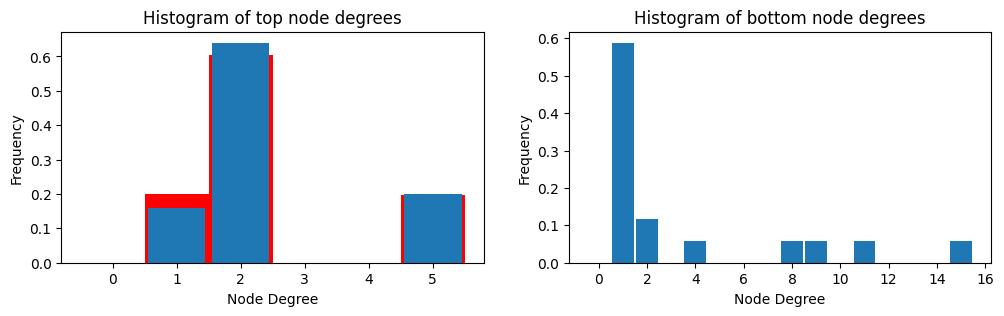

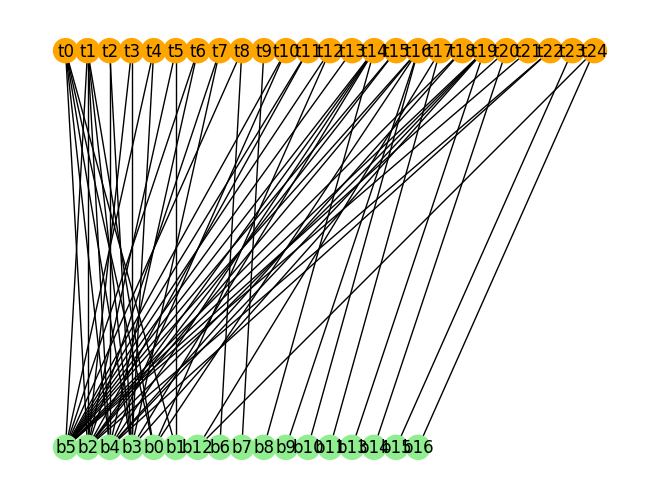

In [10]:
test_distr = stats.rv_discrete(name='custm', values=([1, 2, 5], [1/5, 3/5, 1/5]))
G = bipartite_graph_generator(test_distr,25,0.75)
analyize_distributions_bipartite_graph(G,distribution=test_distr)
draw_bipartite_graph(G,sort_top=False)

### Test 2

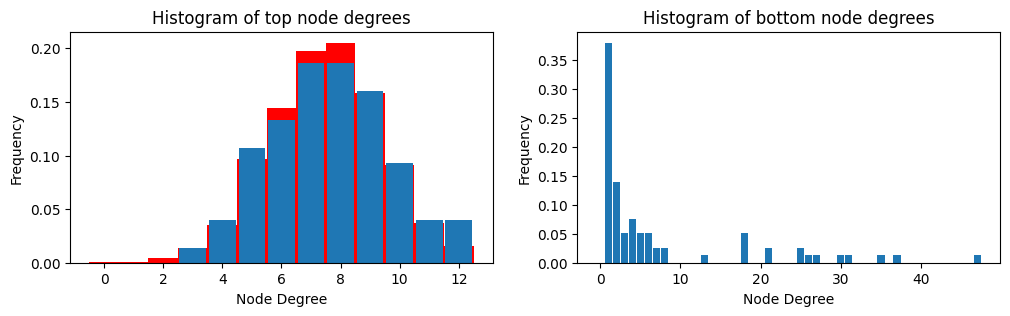

In [11]:
binomial = stats.binom(15, 0.5)
G = bipartite_graph_generator(binomial,75,0.85)
analyize_distributions_bipartite_graph(G,distribution=binomial)

### Test 3

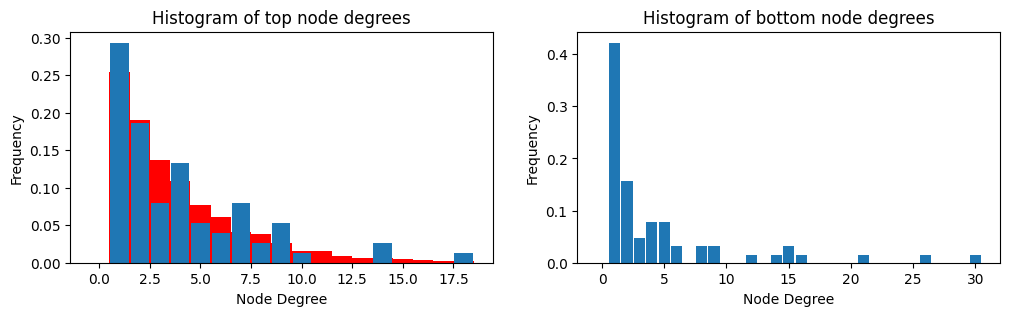

In [12]:
geometric = stats.geom(0.25)
G = bipartite_graph_generator(geometric,75,0.85)
analyize_distributions_bipartite_graph(G,distribution=geometric)

### Test 4

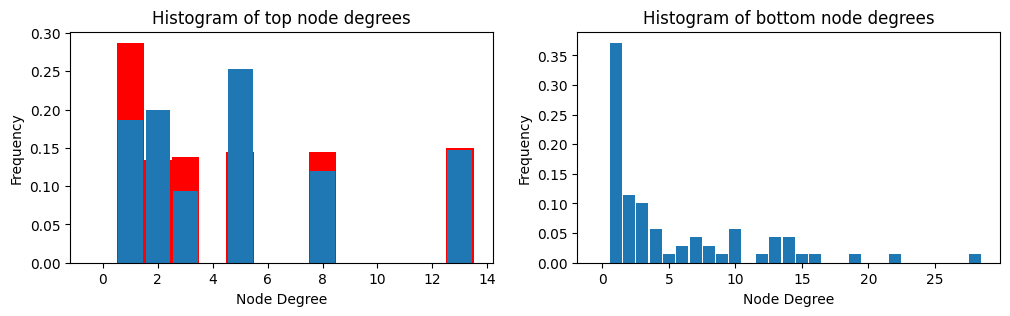

In [13]:
uniform_trunc_fibonacci = stats.rv_discrete(name='custm', values=([1, 2, 3, 5, 8, 13], [2/7,1/7,1/7,1/7,1/7,1/7]))
G = bipartite_graph_generator(uniform_trunc_fibonacci,75,0.85)
analyize_distributions_bipartite_graph(G,distribution=uniform_trunc_fibonacci)

## Implementation of projection and analysis

**Implement** the functions for the analysis of graphs.
You can use your own implementation or the [networkx](https://networkx.github.io/documentation/stable/) implementations.
*Hint: When using networkx the functions can mostly be written as one-liners.*


**Implement** a projection of the graph onto both the top and bottom node sets. Use the [networkx implementation](https://networkx.github.io/documentation/networkx-1.9/reference/algorithms.bipartite.html) to do this.
*Hint: You can use the [G.nodes(data=true)](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.nodes.html) flag to get the nodes with their corresponding attribute dictionary.*


In [14]:
def Connected(G):
    # connectedness of G
    connected = nx.is_connected(G)
    return connected

def ASP(G):
    # average shortest path in G
    if Connected(G):
        ASP = nx.average_shortest_path_length(G)
        return ASP
    else:
        return float('inf')

def ALCC(G):
    # average clustering coefficient of G
    if Connected(G):
        ALCC = nx.average_clustering(G)
        return ALCC
    else:
        return -1
    
def NumNodes(G):
    # number of nodes of G
    return G.number_of_nodes()

def NumEdges(G):
    # number of edges of G
    return G.number_of_edges()

def Density(G):
    # density of G
    Density = nx.density(G)
    return Density

def ADeg(G):
    # average degree of G
    ADeg = sum(dict(G.degree()).values()) / G.number_of_nodes()
    return ADeg


def project_bipartite_graph(G, attribute='bipartite'):
    # computes the projections onto the top and bottom node sets of a bipartite graph

    # Separate top and bottom nodes based on bipartite attribute
    top_nodes = {n for n, d in G.nodes(data=True) if d[attribute] == 0}
    bottom_nodes = set(G) - top_nodes

    # Create projections
    top_graph = bipartite.projected_graph(G, top_nodes)
    bottom_graph = bipartite.projected_graph(G, bottom_nodes)
    
    return top_graph, bottom_graph

In [15]:
# compute all functions for a graph
functions = [Connected, NumNodes, NumEdges, ASP, ALCC, Density, ADeg]
def functions_on_graph(G,functions):
    return list(map(lambda f:(f.__name__,f(G)),functions))


## Evaluation of generated and projected bipartite graphs

**Generate** bipartite graphs given the following parameters:

1. **Graph 1**
    * Distribution: Binomial(15, 0.5) -> stats.binom(15, 0.5)
    * Number of Top Nodes: 150
    * Overlap Ratio: 0.85
    
    
2. **Graph 2**
    * Distribution: Geometric(0.1) -> stats.geom(0.1)
    * Number of Top Nodes: 100
    * Overlap Ratio: 0.95
    
    
3. **Graph 3**
    * Distribution: Discrete Distribution with P(3)=0.1; P(6)=0.5; P(9)=0.3; P(15)=0.1 -> see Test 4 for an example of a custom discrete distribution
    * Number of Top Nodes: 150
    * Overlap Ratio: 0.5
    
---
    
**Analyze** the graphs with respect to:
* connectedness
* average shortest path
* density
* average degree

---

**Project** the graph onto both the top and bottom node sets and **analyze** the projected graphs with respect to:
* connectedness
* average shortest path
* average local clustering coefficient
* density
* average degree

---

**Try to generate connected graphs**. 
Notice that a correctly implemented generator does not guarantee connectedness.
Compare the results of the projections and the original graph.
Write a **short** summary of your observations, e.g., what is similar, what is not, what changes for the projections etc.

### Graph 1

In [16]:
binomial = stats.binom(15, 0.5)
G = bipartite_graph_generator(binomial,150,0.85)

# Analyze graph and projections
top_proj, bot_proj = project_bipartite_graph(G)
print("Original:", functions_on_graph(G, functions))
print("Top Projection:", functions_on_graph(top_proj, functions))
print("Bottom Projection:", functions_on_graph(bot_proj, functions))

Original: [('Connected', True), ('NumNodes', 347), ('NumEdges', 1144), ('ASP', 3.406906431676967), ('ALCC', 0.0), ('Density', 0.019056820642667956), ('ADeg', 6.593659942363113)]
Top Projection: [('Connected', True), ('NumNodes', 150), ('NumEdges', 8307), ('ASP', 1.2566442953020134), ('ALCC', 0.8240701331472021), ('Density', 0.7433557046979866), ('ADeg', 110.76)]
Bottom Projection: [('Connected', True), ('NumNodes', 197), ('NumEdges', 2027), ('ASP', 2.042111260747954), ('ALCC', 0.8137225009962512), ('Density', 0.10499326634206982), ('ADeg', 20.578680203045685)]


#### Observations:

- **Original**: Connected, ASP ≈ 3.22, ALCC = 0, Density ≈ 0.021
- **Projections**: 
  - Top: High clustering (0.89), ASP ≈ 1.16, much denser
  - Bottom: Similar trends with ASP ≈ 1.97
- **Observation**: High overlap → dense projections with strong clustering and short paths.


### Graph 2

In [17]:
geom = stats.geom(0.1)
G = bipartite_graph_generator(geom, 100, 0.95)

# Analyze graph and projections
top_proj, bot_proj = project_bipartite_graph(G)
print("Original:", functions_on_graph(G, functions))
print("Top Projection:", functions_on_graph(top_proj, functions))
print("Bottom Projection:", functions_on_graph(bot_proj, functions))

Original: [('Connected', True), ('NumNodes', 167), ('NumEdges', 952), ('ASP', 2.7350119039030374), ('ALCC', 0.0), ('Density', 0.06868191328187), ('ADeg', 11.401197604790418)]
Top Projection: [('Connected', True), ('NumNodes', 100), ('NumEdges', 3411), ('ASP', 1.3109090909090908), ('ALCC', 0.8610488358862881), ('Density', 0.6890909090909091), ('ADeg', 68.22)]
Bottom Projection: [('Connected', True), ('NumNodes', 67), ('NumEdges', 1430), ('ASP', 1.360922659430122), ('ALCC', 0.8853031483075274), ('Density', 0.6467661691542289), ('ADeg', 42.6865671641791)]


#### Observations: 

- **Original**: Connected, ASP ≈ 2.84, ALCC = 0, Density ≈ 0.058
- **Projections**:
  - Top: ASP ≈ 1.32, ALCC ≈ 0.87, high average degree (67.36)
  - Bottom: Similar results, ASP ≈ 1.48
- **Observation**: Very high overlap makes projections highly clustered and compact.

### Graph 3

In [18]:
xk = [3, 6, 9, 15]
pk = [0.1, 0.5, 0.3, 0.1]
some_discrete_dist = stats.rv_discrete(name='custom', values=(xk, pk))
G = bipartite_graph_generator(some_discrete_dist, 150, 0.5)

# Analyze graph and projections
top_proj, bot_proj = project_bipartite_graph(G)
print("Original:", functions_on_graph(G, functions))
print("Top Projection:", functions_on_graph(top_proj, functions))
print("Bottom Projection:", functions_on_graph(bot_proj, functions))

Original: [('Connected', True), ('NumNodes', 712), ('NumEdges', 1128), ('ASP', 5.177531250493844), ('ALCC', 0.0), ('Density', 0.00445645474802067), ('ADeg', 3.168539325842697)]
Top Projection: [('Connected', True), ('NumNodes', 150), ('NumEdges', 2047), ('ASP', 1.9764653243847874), ('ALCC', 0.4994907844590683), ('Density', 0.18317673378076063), ('ADeg', 27.293333333333333)]
Bottom Projection: [('Connected', True), ('NumNodes', 562), ('NumEdges', 4065), ('ASP', 2.754530864432476), ('ALCC', 0.8084662169143008), ('Density', 0.025786438807163112), ('ADeg', 14.466192170818506)]


#### Observations:

- **Original**: Connected, ASP ≈ 4.98, ALCC = 0, very sparse (Density ≈ 0.004)
- **Projections**:
  - Top: ASP ≈ 1.86, ALCC ≈ 0.54, Density ≈ 0.21
  - Bottom: ASP ≈ 2.66, ALCC ≈ 0.81
- **Observation**: Lower overlap yields more spread-out structure; projections still denser and more clustered than original.